# Deep Convolutional Generative Adversarial Network

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

<p align='center'><img src='https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1'></img></p>

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

<p align='center'><img src='https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1'></img></p>

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

<p align='center'><img src='https://tensorflow.org/images/gan/dcgan.gif'></img></p>

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
# import
import tensorflow as tf

In [2]:
tf.__version__

'2.15.0'

In [3]:
# To generate GIFs
# !pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_oq5_msu
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_oq5_msu
  Resolved https://github.com/tensorflow/docs to commit ff989f0d94cd81cce45a8db0f540e605ce05512b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.3.27.3713-py3-none-any.whl size=182447 sha256=ec80b9baf7e738bf3183b24581f7e69c486f686644a1b3a7fec7cc6c638fd3a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4nlsdyw/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [4]:
# import
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
# get data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
#rescale
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
# display shape
train_images.shape, type(train_images)

((60000, 28, 28, 1), numpy.ndarray)

In [8]:
# labels
train_labels.shape, type(train_labels), np.unique(train_labels)

((60000,), numpy.ndarray, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

This is the information you need to verify if you use your own dataset.

In [9]:
# args
BUFFER_SIZE = 60000
BATCH_SIZE = 32

In [10]:
60000 / 32

1875.0

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# train_dataset
train_dataset, type(train_dataset)

(<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>,
 tensorflow.python.data.ops.batch_op._BatchDataset)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

We use *assert* for debugging purpose. If there is an error in the code, the *assert* function will raise this error. The API for *assert* is [here](https://www.w3schools.com/python/ref_keyword_assert.asp#:~:text=The%20assert%20keyword%20is%20used,program%20will%20raise%20an%20AssertionError.).

#### Conventional Generator

In [ ]:
# define generator
def make_generator_model():

    # use sequential API
    model = tf.keras.Sequential()

    # start with dense layers
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(784,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # reshape
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    # add Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # add Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # add Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#### Generator with Attention

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def make_generator_model():
    # Input layer
    inputs = layers.Input(shape=(784,))

    # Dense layer for initial processing
    x = layers.Dense(7*7*256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Reshape to fit for multi-head attention
    x = layers.Reshape((49, 256))(x)  # 7*7 = 49

    # MultiHead Attention layer
    # Since 'query', 'key', and 'value' can be the same tensor for self-attention,
    # we pass 'x' three times to the layer.
    attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=64)(x, x, x)
    attention_output = layers.LeakyReLU()(attention_output)

    # Combine attention output with the original sequence
    # Optionally, you might want to combine or process the attention output further
    # before moving on to the next layers; a simple way is to concatenate.
    x = layers.Concatenate(axis=-1)([x, attention_output])

    # Proceed with the model as before
    x = layers.Flatten()(x)
    x = layers.Reshape((7, 7, 512))(x)  # Adjusted due to concatenation

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=x)

    return model


#### Generator U-net

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def make_generator_model():
    inputs = layers.Input(shape=(28, 28, 1))

    # Encoder part
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck with MultiHeadAttention
    # We need to flatten and reshape to apply MultiHeadAttention
    b = layers.Flatten()(p2)
    b = layers.Dense(49*128, activation='relu')(b)  # Adjusted to match the flattened size
    b = layers.Reshape((49, 128))(b)  # Prepare for MultiHeadAttention

    # Applying MultiHeadAttention
    b = layers.MultiHeadAttention(num_heads=4, key_dim=32)(b, b, b)

    # Decoder part, reshaping back to the spatial dimension needed for Conv2DTranspose
    b = layers.Flatten()(b)
    b = layers.Dense(7*7*128, activation='relu')(b)
    b = layers.Reshape((7, 7, 128))(b)

    u1 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(b)
    u1 = layers.BatchNormalization()(u1)

    # Skipping connections
    u1 = layers.concatenate([u1, c2])
    u2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(u1)
    u2 = layers.BatchNormalization()(u2)

    u2 = layers.concatenate([u2, c1])
    outputs = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(u2)

    # Create and compile the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

Use the (as yet untrained) generator to create an image.

(1, 28, 28, 1)


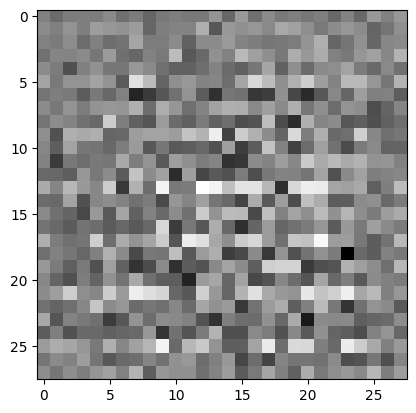

In [50]:
# create generator model
generator = make_generator_model()

# create noise and throw noise into the generator
noise = tf.random.normal([1, 784])
# noise = tf.random.normal([1, 28, 28, 1])
generated_image = generator(noise, training=False)
print(generated_image.shape)

# plot an output from generator that is untrained
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier. Notice that in the beginning of the `make_discriminator_model()` function below the input_shape must be the same as the output shape of the generator.

In [15]:
# define discriminator model
def make_discriminator_model():

    # use sequential API
    model = tf.keras.Sequential()

    # add Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # add Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # flatten and output 1 neuron
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [51]:
# define discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00580299]], shape=(1, 1), dtype=float32)


## How does GAN learn?

According to the [original paper](https://arxiv.org/pdf/1406.2661.pdf), we can set up the situation as the following. Suppose the discriminator is $D(x; \theta_d)$ using noisy data $x \sim p_z(z)$ where $p_z$ is some prior distribution and the generator is $G(z; \theta_g)$. Then the goal is to learn to train $D$ to maximize the probability of assigning the correct label to both training examples and samples from $G$. We simultaneously train $G$ to minimize $\log(1 - D(G(z)))$.

In other words, $D$ and $G$ play the following two-layer minimax game with the objective function $\mathcal{V}(G, D)$:
$$ \min_G \max_D \mathcal{V}(D, G) = \mathbb{E}_{x \sim p_{\text{data}(x)}} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))]$$

In each learning step, the gradient for the discriminator is updated:
$$\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^m [\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))]$$
where $m$ refers to samples and the gradient is taken w.r.t $\theta_d$ (parameters for the discriminator $D$).

The gradient for the generator is updated:
$$\nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m \log(1 - D(G(z^{(i)})))$$
where $m$ refers to the samples and the gradient is taken w.r.t. $\theta_g$ (parameters for the generator $G$).

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [52]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [53]:
# def loss for generator
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [54]:
# check
tf.ones_like([1,2,3]), tf.zeros_like([1,2,3])

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>)

In [55]:
# def loss for discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Optimizers

The discriminator and the generator optimizers are different since you will train two networks separately.

In [56]:
# define two separate optimizer for the generator and the discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [22]:
# save and checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [57]:
# args
EPOCHS = 3
noise_dim = 100
num_examples_to_generate = 25

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [58]:
# check
seed.shape, type(seed)

(TensorShape([25, 100]), tensorflow.python.framework.ops.EagerTensor)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [66]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, twoDim=False):
    # Flatten and mask the images instead of using random noise
    # Example mask: setting a random portion of the image to zero
    # This is a simple mask that zeroes out half of the image
    delta = 0
    # mask = tf.concat([tf.ones(shape=(784//2-delta,)), tf.zeros(shape=(784//2+delta,))], 0)
    # mask = tf.random.shuffle(mask)
    mask = np.ones((28, 28), dtype=np.float32)
    # Set the bottom right portion of the mask to 1
    mask[14:, 14:] = 0
    # Convert the numpy array to a TensorFlow tensor
    mask = mask.reshape(784, )
    mask = tf.convert_to_tensor(mask)
    flat_images = tf.reshape(images, [BATCH_SIZE, 784])
    masked_images = flat_images * mask
    if twoDim:
        masked_images = tf.reshape(masked_images, [BATCH_SIZE, 28, 28, 1])

    # args
    # noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # use gradient tape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(masked_images, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Notice that the `train()` function saves images in the current directory.

In [67]:
from tqdm import tqdm

In [68]:
# training
def train(dataset, epochs):

    # for loop: this loop iterates epochs
    for epoch in range(epochs):
        start = time.time()

        # for loop: iterate images in the dataset
        for image_batch in tqdm(dataset):
            train_step(image_batch)

        # produce images for the GIF as you go
        # display.clear_output(wait=True)
        # generate_and_save_images(
        #     generator,
        #     epoch + 1,
        #     seed)

        # save the model every 15 epochs
        # if (epoch + 1) % 15 == 0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)

        # print statement
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('...')
        print('...')
        print('...')
        print('...')

        # generate after the final epoch
        # display.clear_output(wait=True)
        # generate_and_save_images(generator, epochs, seed)

**Generate and save images**


In [69]:
# # def function
# def generate_and_save_images(model, epoch, test_input):
#     # Notice `training` is set to False.
#     # This is so all layers run in inference mode (batchnorm).
#     predictions = model(test_input, training=False)

#     # figure
#     fig = plt.figure(figsize=(5, 5))
#     for i in range(predictions.shape[0]):
#         plt.subplot(5, 5, i+1)
#         if i == 0:
#             plt.title('ep='+str(epoch))
#         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#         plt.axis('off')

#     # save and display
#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#     plt.show()

## Train the model

Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [70]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [71]:
%%time

# train
with tf.device('/device:GPU:0'):
    train(train_dataset, 1)

100%|██████████| 1875/1875 [00:29<00:00, 62.62it/s]

Time for epoch 1 is 29.94382071495056 sec
...
...
...
...
CPU times: user 13.4 s, sys: 2.47 s, total: 15.8 s
Wall time: 29.9 s


Restore the latest checkpoint.

## Inference

In [72]:
def make_inference(input_image, generator, twoDim=False):
    # Ensure input_image is a tensor
    if not isinstance(input_image, tf.Tensor):
        input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)

    # Flatten the input image and apply the mask
    delta = 0
    # mask = tf.concat([tf.ones(shape=(784//2-delta,)), tf.zeros(shape=(784//2+delta,))], 0)
    # Create a binary mask of size 28x28
    mask = np.ones((28, 28), dtype=np.float32)
    # Set the bottom right portion of the mask to 1
    mask[14:, 14:] = 0
    # Convert the numpy array to a TensorFlow tensor
    mask = mask.reshape(784, )
    mask = tf.convert_to_tensor(mask)
    # print(mask.shape)

    # mask = tf.random.shuffle(mask)
    flat_image = tf.reshape(input_image, [784])
    masked_image = flat_image * mask
    if twoDim:
        masked_image = tf.reshape(masked_image, [28, 28, 1])

    # Since the generator expects a batch dimension, add a batch dimension to the masked image
    masked_image = tf.expand_dims(masked_image, 0)  # Adds a batch dimension

    # Generate the image using the generator
    # masked_image_for_gen = masked_image[:, 0:392]
    generated_image = generator(masked_image, training=False)  # Set training to False for inference

    return masked_image, generated_image


In [73]:
masked_output_, output_ = make_inference(train_images[0], generator)

print(masked_output_.shape, output_.shape)

(1, 784) (1, 28, 28, 1)


## Loop: Train + Inference

In [74]:
%%time

for k in range(50):

    # train
    with tf.device('/device:GPU:0'):
        train(train_dataset, EPOCHS)

    # Assuming 'train_images' and 'train_labels' are defined and 'generator' is your model
    plt.figure(figsize=(20, 4))  # Adjusted size for better visibility
    T = 20

    # Display real images
    for i in range(T):
        plt.subplot(3, T, i + 1)
        plt.imshow(train_images[i], cmap='gray')
        plt.title(f"Real: {train_labels[i]}")
        plt.axis('off')

    # Display fake images generated by the model
    for i in range(T):
        masked_output_, output_ = make_inference(train_images[i], generator)
        masked_output_ = tf.reshape(masked_output_, [28, 28])
        plt.subplot(3, T, i + T + 1)  # +7 to move to the second row, right below the corresponding real image
        plt.imshow(masked_output_, cmap='gray')  # Adjust indexing if needed
        plt.title(f"Masked: {train_labels[i]}")
        plt.axis('off')

    # Display fake images generated by the model
    for i in range(T):
        masked_output_, output_ = make_inference(train_images[i], generator)
        plt.subplot(3, T, i + T + T + 1)  # +7 to move to the second row, right below the corresponding real image
        plt.imshow(output_[0, :, :, 0], cmap='gray')  # Adjust indexing if needed
        plt.title(f"Gen.: {train_labels[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Chk point
    print("===============================!")
    print(f"Checkpoint {k+1}")


Output hidden; open in https://colab.research.google.com to view.

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. It is an adaption from this [Tensorflow notebook](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb). As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
